In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as f
import torchvision
import torchvision.datasets as dt
import torchvision.transforms as tr
import tqdm
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
import torch.optim as op

In [2]:
tran=tr.Compose([tr.ToTensor(),tr.Normalize((0.5,),(0.5,))])

In [3]:
trainset = dt.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=tran)
valset = dt.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=tran)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw

Processing...
Done!


In [4]:
bs=32
nepochs=10


In [5]:
traindataloader=torch.utils.data.DataLoader(trainset,batch_size=bs,shuffle=True)
valdataloader=torch.utils.data.DataLoader(valset,batch_size=bs,shuffle=True)

In [6]:
for i in traindataloader:
  print(i[0].shape)
  print(i[1].shape)
  print(i[1])
  break

torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([1, 0, 5, 2, 7, 2, 7, 5, 0, 6, 3, 6, 2, 5, 5, 3, 1, 9, 1, 5, 7, 6, 4, 6,
        1, 3, 6, 4, 6, 6, 6, 4])


In [7]:
class model(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1=nn.Linear(784,500)
    self.drp1=nn.Dropout(0.3)
    self.fc2=nn.Linear(500,500)
    self.drp2=nn.Dropout(0.3)
    self.fc3=nn.Linear(500,10)
  
  def forward(self,x):
    out=f.leaky_relu(self.drp1(self.fc1(x)))
    out=f.leaky_relu(self.drp2(self.fc2(out)))
    return self.fc3(out)

In [8]:
m1=model()

In [9]:
device=torch.device("cuda:0")

In [10]:
m1=m1.to(device)

In [11]:
adam=op.Adam([{"params":m1.fc1.parameters(),'lr':0.001},{"params":m1.fc2.parameters(),'lr':0.0005},{"params":m1.fc3.parameters(),'lr':0.0005}],0.0001)

In [12]:
loss=nn.CrossEntropyLoss()

In [13]:
traindataloader.__len__()

1875

In [14]:
trainloss=[]
for i in tqdm.tqdm(range(nepochs)):
  for j in tqdm.tqdm(traindataloader):
    adam.zero_grad()
    batchx,batchy=j
    batchx=batchx.reshape(32,-1)
    batchx=batchx.to(device)
    batchy=batchy.to(device)
    pred=m1(batchx)
    ls=loss(pred,batchy)
    ls.backward()
    adam.step()
    trainloss.append(ls.item())


100%|██████████| 10/10 [01:59<00:00, 11.98s/it]


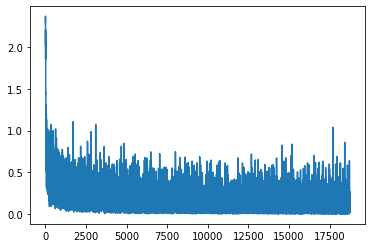

In [15]:
plt.plot(trainloss)

In [16]:
m1.eval()

model(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (drp1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (drp2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
)

TypeError: ignored

In [18]:
valpred=[]
vallabels=[]
with torch.no_grad():
  for j in tqdm.tqdm(valdataloader):
    batchx,batchy=j
    batchx=torch.flatten(batchx,1,-1).to(device)
    valpred.append(m1.forward(batchx).detach().to("cpu").numpy())
    vallabels.append(batchy)



100%|██████████| 313/313 [00:01<00:00, 235.35it/s]


In [19]:
valpred=[t.argmax(-1) for t in valpred]

In [20]:
valpred=np.concatenate(valpred)

In [21]:
valpred

array([2, 0, 9, ..., 2, 0, 8])

In [22]:
vallabels=np.concatenate([i.numpy() for i in vallabels])

In [23]:
accuracy_score(valpred,vallabels)

0.9753

In [24]:
torch.save(m1.state_dict(),'mod.pth')

In [25]:
!ls -l

total 2548
-rw-r--r-- 1 root root 2594341 Apr 12 19:06 mod.pth
drwxr-xr-x 3 root root    4096 Apr 12 19:03 PATH_TO_STORE_TESTSET
drwxr-xr-x 3 root root    4096 Apr 12 19:03 PATH_TO_STORE_TRAINSET
drwxr-xr-x 1 root root    4096 Apr  7 13:36 sample_data


In [26]:
sum([t.numel() for t in m1.parameters()])

648010

In [53]:
class cnnmodel(nn.Module):
  def __init__(self,nclasses,shape):
    super().__init__()
    self.cnn1=nn.Conv2d(1,16,3)
    self.p1=nn.MaxPool2d(2)
    self.cnn2=nn.Conv2d(16,16,3)
    self.p2=nn.MaxPool2d(2)
    self.cnn3=nn.Conv2d(16,8,3)
    d=self.getdim()
    self.fc1=nn.Linear(d,nclasses)
    self.shape=shape

  def forward(self,x):
    out=f.leaky_relu(self.p1(self.cnn1(x)))
    out=f.leaky_relu(self.p2(self.cnn2(out)))
    out=f.leaky_relu(self.cnn3(out))
    out=torch.flatten(out,1,-1)
    return self.fc1(out)

  def getdim(self):
    t=torch.zeros(1,1,28,28)
    return self.cnn3(self.p2(self.cnn2(self.p1(self.cnn1(t))))).reshape(-1,).numel()


In [54]:
cnn1=cnnmodel(10,(1,28,28))

In [39]:
sum([t.numel() for t in cnn1.parameters()])

4370

In [55]:
tau=10

In [56]:
loss1=nn.CrossEntropyLoss()
op2=op.Adam(cnn1.parameters(),lr=0.001)

In [57]:
cnn1=cnn1.to(device)

In [58]:
trainloss1=[]
for i in tqdm.tqdm(traindataloader):
  teacherlogits=m1(torch.flatten(i[0],1,-1).to(device))
  teacherprob=f.softmax(teacherlogits/tau).data

  op2.zero_grad()
  studentlogits=cnn1(i[0].to(device))

  l=-1*((teacherprob*(f.log_softmax(studentlogits/tau,dim=1))).sum(dim=1)).mean()
  l.backward()
  op2.step()
  trainloss1.append(l.item())
  


  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
100%|██████████| 1875/1875 [00:12<00:00, 153.02it/s]


In [59]:
cnn1.eval()

cnnmodel(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (p2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=72, out_features=10, bias=True)
)

In [60]:
valpred=[]
vallabels=[]
with torch.no_grad():
  for j in tqdm.tqdm(valdataloader):
    batchx,batchy=j
    batchx=batchx.to(device)
    valpred.append(cnn1.forward(batchx).detach().to("cpu").numpy())
    vallabels.append(batchy)

100%|██████████| 313/313 [00:01<00:00, 230.40it/s]


In [61]:
valpred=[t.argmax(-1) for t in valpred]
valpred=np.concatenate(valpred)
vallabels=np.concatenate([i.numpy() for i in vallabels])
accuracy_score(valpred,vallabels)

0.9451